# Machine Learning Models for Bacteria Classification using 16S RNA Short-Reads

Diego Godinez Bravo

MSc Statistical Computing at Mathematics Research Center (CIMAT)

## About the Project

Taxonomy is one of the most relevant scientific disciplines in biology. Initially, the characterization and classification of species relied exclusively on phenotypic traits. Today, bacterial systematics and taxonomy have evolved to incorporate molecular information. The advent of modern sequencing methods has optimized and scaled the analysis of complete genomes, with shotgun sequencing and amplicon sequencing standing out.

This project addresses taxonomic work using short sequences obtained through amplicon sequencing of the small subunit ribosomal RNA (16S rRNA). The genomic data analysis involves feature extraction through the representation of subsequence frequencies, known as k-mers. Additionally, high-dimensional data visualization techniques are applied, alongside Machine Learning (ML) models, to explore underlying patterns in the data, identify differences in nucleotide composition between sequences, and effectively classify species at various hierarchical levels.

## Data Description

The metagenomic data used in this study come from the work published by Fiannaca *et al.* (2018). These are simulated data from an amplicon sequencing process, based on the 16S ribosomal RNA (rRNA) gene corresponding to the small ribosomal subunit. For the simulation, only the hypervariable V3-V4 regions (approximately 469 bp) were selected, as these less conserved regions have been widely reported as discriminative for species identification and classification.

The dataset includes 28,000 short sequences, which were processed to remove the primers. The data is available at the following URL: http://tblab.pa.icar.cnr.it/public/BMC-CIBB_suppl/datasets/

***

A. Fiannaca, et al., Deep learning models for bacteria taxonomic classification of metagenomic data, BMC Bioinformatics 18 (2017) S19, 10.1186/s12859-017-1971-6

In [ ]:
pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.2 MB/s eta 0:00:00


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from itertools import product
from collections import Counter
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay # loading libraries

## Reading and Analyzing Data from a FASTA File

In [ ]:
short_reads = 0
for record in SeqIO.parse('AMP.fasta', 'fasta'):
  short_reads += 1
print('\nThere are {} 16S short reads.'.format(short_reads))


There are 28000 16S short reads.


In [ ]:
with open('AMP.fasta') as FastaFile:
  sequences = {} # empty dictionary to store sequences
  current_header = None

  for line in FastaFile:
    line = line.strip() # remove any leading/trailing whitespaces
    if line.startswith('>'): # identifying starting positions of 16S short reads
      current_header = line # header
      sequences[current_header] = ""
    else:
      sequences[current_header] += line # append sequence line

In [ ]:
for i, (header, sequence) in enumerate(sequences.items()):
  if i >= 5:  # print first 5 entries
    break
  print("{}\n{}\n".format(header, sequence))

>1_S003714807 Root;Bacteria;Proteobacteria;Gammaproteobacteria;Alteromonadales;Alteromonadaceae;Marinobacter
TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATACCGCGTGTGTGAAGAAGGCTTTCGGGTTGTAAAGCACATTCAGTGAGGAGGATGGCCTTAAGTTTAATACGCTTGAGGATTGACGTCTCCAAGTAAGAGAGTACACGGGTAAACCTTGCCAGCAGGGGCGCCGAGACCTGGATGGCGCCGCGAGCAGTATAGTTGTTGCCCAATGTAGGCTCTGTGCCGTAAGCTCGAATCGC

>2_S000412960 Root;Bacteria;Proteobacteria;Betaproteobacteria;Neisseriales;Neisseriaceae;Kingella
TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGTCTGAAGAAGGCCTTCGGGTTGTAAAGGACTTTTGTTAGGGAAGAAAAGTCTGATGCTAATATCATTGGCTGATGATGGTACCTAAAGAATTAGGACCGCCTACCGAAGCCACGAGCCGCGGTTGTTGACGTTGGGTCTTAGGTTGATCGCGTAACATCGGGGGTGCTCTGTGCAC

>3_S001872179 Root;Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Aggregatibacter
TGGGGAATATTGCGCAATGGGGGCAACCCTGACGCAGGCAAGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTCTTCGGTGATGAGGAAGGTGGGTGTGTTAATAGCATGCAAACTTGACTTCACCATAGAGAAGGGCAGGCTGACTCCGGAGTGCAAAGACGACGTTACGGCGGGTCCTTAGGCTAAACGGGGTACGCGCCATA

In [ ]:
genus = [] # empty list to store genera
classes = [] # empty list to store classes
order = []
for key, seq in sequences.items():
  taxonomy = key.split(';')
  classes.append(taxonomy[-4]) # extract and store the class
  order.append(taxonomy[-3]) # extract
  genus.append(taxonomy[-1]) # extract and store the genus; here, it represents the final taxonomic level since the species name is missing

In [ ]:
classes[:5] # list containing all the orders

['Gammaproteobacteria',
 'Betaproteobacteria',
 'Gammaproteobacteria',
 'Betaproteobacteria',
 'Alphaproteobacteria']

In [ ]:
print('The class list contains {} values, with {} distinct classes.'.format(len(classes), len(list(set(classes)))))

The class list contains 28000 values, with 3 distinct classes.


In [ ]:
order[:5] # list containing all the orders

['Alteromonadales',
 'Neisseriales',
 'Pasteurellales',
 'Neisseriales',
 'Rhodobacterales']

In [ ]:
print('The order list contains {} values, with {} distinct orders.'.format(len(order), len(list(set(order)))))

The order list contains 28000 values, with 20 distinct orders.


In [ ]:
genus[:5] # list containing all the genera

['Marinobacter',
 'Kingella',
 'Aggregatibacter',
 'Pseudogulbenkiania',
 'Aliiroseovarius']

In [ ]:
print('The genus list contains {} values, with {} distinct genera.'.format(len(genus), len(list(set(genus)))))

The genus list contains 28000 values, with 96 distinct genera.


In [ ]:
short_reads = [] # empty list to store sequences
for key, seq in sequences.items():
  short_reads.append(seq) # store the sequence

In [ ]:
short_reads[:5] # list containing all the 16S short reads

['TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATACCGCGTGTGTGAAGAAGGCTTTCGGGTTGTAAAGCACATTCAGTGAGGAGGATGGCCTTAAGTTTAATACGCTTGAGGATTGACGTCTCCAAGTAAGAGAGTACACGGGTAAACCTTGCCAGCAGGGGCGCCGAGACCTGGATGGCGCCGCGAGCAGTATAGTTGTTGCCCAATGTAGGCTCTGTGCCGTAAGCTCGAATCGC',
 'TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGTCTGAAGAAGGCCTTCGGGTTGTAAAGGACTTTTGTTAGGGAAGAAAAGTCTGATGCTAATATCATTGGCTGATGATGGTACCTAAAGAATTAGGACCGCCTACCGAAGCCACGAGCCGCGGTTGTTGACGTTGGGTCTTAGGTTGATCGCGTAACATCGGGGGTGCTCTGTGCAC',
 'TGGGGAATATTGCGCAATGGGGGCAACCCTGACGCAGGCAAGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTCTTCGGTGATGAGGAAGGTGGGTGTGTTAATAGCATGCAAACTTGACTTCACCATAGAGAAGGGCAGGCTGACTCCGGAGTGCAAAGACGACGTTACGGCGGGTCCTTAGGCTAAACGGGGTACGCGCCATAGAACCCTCATTCAC',
 'TGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGTCTGAAGAAGGCCTTCGGGTTGTAAAGGACTTTTGTCCGGGATCAAAGCCTACATGCTAATACCGAGTGGGGATGAGAGTACCGCGAAGAAAAAGCAGCCGGCTAACTACGAGCCAGCAGCCGAGGTAATACGTAGTGTCCGGGCGTACTCCAAAATGTGTGCCTTACTGCGACCCAGTTTGATATC',
 'TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGCGTG

## Feature Extraction

### Finding All K-mers from a FASTA File

k-mers are subsequences of length $k$ extracted from a longer sequence, in this case short-read sequences of 16S rRNA. They capture the composition and frequency of nucleotide patterns within a sequence.

In [ ]:
def kmers(sequence, k):
  return [sequence[i:i+k] for i in range(len(sequence) - k + 1)] # return a list with all the kmers from the given sequence

In [ ]:
def kmers_short_reads(dictionary, k):
  kmers_list = [] # empty list to store kmers from all short reads in the sequences dictionary
  for key, seq in dictionary.items(): # iterate through all sequences
    kmers_list.append(kmers(seq, k)) # apply the kmer function to each sequence and store the results
  return kmers_list

In [ ]:
k = 6 # k value
klist = kmers_short_reads(sequences, k)

In [ ]:
print('There are {} lists of k-mers, each corresponding to a 16S short read,\nwith every k-mer having a length of {}.'.format(len(klist), k))

There are 28000 lists of k-mers, each corresponding to a 16S short read,
with every k-mer having a length of 6.


### Generating Feature Vectors from K-mers

In [ ]:
def feature_vectors(kmers_list, k):
  nucleotides = ['A', 'T', 'G', 'C']
  all_kmers = ["".join(kmer) for kmer in product(nucleotides, repeat = k)] # set of all possible kmers of length k = 6
  features = [] # empty list to store feature vectors

  for kmers in kmers_list:
    kmer_freq = Counter(kmers) # create a collection where elements are stored as dict keys and their count as dict values
    feature_vector = [kmer_freq.get(kmer, 0) for kmer in all_kmers] # get() method retrieve the value for a specified key, it returns a default value if the key is not found
    features.append(feature_vector)

  return features

In [ ]:
features = feature_vectors(klist, k)

In [ ]:
print('There are {} feature vectors, each corresponding to a 16S short read.'.format(len(features)))

There are 28000 feature vectors, each corresponding to a 16S short read.


In [ ]:
AMP = pd.DataFrame({'Class': classes, 'Order': order, 'Genus': genus, '16S Short Reads': short_reads,
                   'K-mers': klist, 'Features': features}) # create a pandas dataframe

In [ ]:
AMP.head() # dataframe preview

,Class,Order,Genus,16S Short Reads,K-mers,Features
0,Gammaproteobacteria,Alteromonadales,Marinobacter,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATACCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Betaproteobacteria,Neisseriales,Kingella,TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATT, GAATTT, AATTT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,Gammaproteobacteria,Pasteurellales,Aggregatibacter,TGGGGAATATTGCGCAATGGGGGCAACCCTGACGCAGGCAAGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Betaproteobacteria,Neisseriales,Pseudogulbenkiania,TGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATT, GAATTT, AATTT...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,Alphaproteobacteria,Rhodobacterales,Aliiroseovarius,TGGGGAATCTTAGACAATGGGCGCAAGCCTGATCTAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATC, GAATCT, AATCT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
AMP.tail()

,Class,Order,Genus,16S Short Reads,K-mers,Features
27995,Betaproteobacteria,Neisseriales,Neisseria,TGGGGAATTTTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATT, GAATTT, AATTT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
27996,Alphaproteobacteria,Rhizobiales,Xanthobacter,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27997,Gammaproteobacteria,Oceanospirillales,Amphritea,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27998,Gammaproteobacteria,Oceanospirillales,Halovibrio,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
27999,Alphaproteobacteria,Rhizobiales,Xanthobacter,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
AMP.shape # 28,000 observations, 6 columns

(28000, 6)

## Assessing Class Imbalance

In [ ]:
AMP['Genus'].value_counts() # class imbalance

,count
Genus,
Nicoletella,344
Histophilus,340
Kingella,340
Phyllobacterium,337
Pseudophaeobacter,336
...,...
Methylobacillus,235
Neorhizobium,226
Erythrobacter,225


The main problem of imbalanced classes in a dataset arises because ML models are typically designed to maximize overall accuracy or minimize error, which can lead to poor performance for the minority class. This occurs because the model tends to favor the majority class, which dominates the data distribution, and treats the minority class as noise.

In [ ]:
min(AMP['Genus'].value_counts()) # minimum no. of observations for a specific genus

182

Our main objective is to classify **bacterial genera**. To achieve this, we'll balance the classes at the taxonomic level of genera. This approach also help us to reduce the number of observations, improving the efficiency of ML models, as the dataset is very large and **excessive run times could become a limitation**.

**UPDATE**

The `StratifiedKFold` method takes over six hours to run with n = 60, prompting us to reduce the number of splits to n = 30 to optimize computational efficiency.

In [ ]:
AMP_updated = (AMP.groupby('Genus').apply(lambda x: x.sample(n = 30, random_state = 42) if len(x) >= 30 else None).reset_index(drop = True)) # reduce the no. of observations to n per genus

In [ ]:
AMP_updated.head() # dataframe preview

,Class,Order,Genus,16S Short Reads,K-mers,Features
0,Gammaproteobacteria,Pasteurellales,Actinobacillus,TGGGGAATATTGCACAATGGGGGGAACCCTGATGCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Gammaproteobacteria,Pasteurellales,Actinobacillus,TGGGGAATATTGCACAATGGGGGGAACCCTGATGCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,Gammaproteobacteria,Pasteurellales,Actinobacillus,TGGGGAATATTGCACAATGGGGGGAACCCTGATGCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,Gammaproteobacteria,Pasteurellales,Actinobacillus,TGGGGAATATTGCACAATGGGGGGAACCCTGATGCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Gammaproteobacteria,Pasteurellales,Actinobacillus,TGGGGAATATTGCACAATGGGGGGAACCCTGATGCAGCCATGCCGC...,"[TGGGGA, GGGGAA, GGGAAT, GGAATA, GAATAT, AATAT...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [ ]:
AMP_updated.shape # 9600 observations, 6 columns

(2880, 6)

In [ ]:
AMP_updated['Genus'].value_counts() # no. of instances per class

,count
Genus,
Actinobacillus,30
Afipia,30
Psychromonas,30
Pseudoxanthomonas,30
Pseudophaeobacter,30
...,...
Kingella,30
Histophilus,30
Halovibrio,30


In [ ]:
X = np.array(AMP_updated['Features'].tolist()) # features
y = AMP_updated['Genus'] # labels

 Each row in the feature array represents the **presence or absence** of specific k-mers in the entire k-mer space (frequency representation).

In [ ]:
X.shape

(2880, 4096)

In [ ]:
y.shape

(2880,)

## Dimensionality Reduction Techniques for Genomic Data Exploration

### t-distributed Stochastic Neighbor Embedding

t-distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised non-linear dimensionality reduction technique for visualize high-dimensional data. It gives us an idea on how data is arranged in higher dimensions. It's often used to visualize complex datasets into two or three dimensions, helping us to explore potential underlying patterns and relationships in the data.

In [ ]:
X_embedded = TSNE(n_components = 2, learning_rate = 'auto',
                  init = 'random', perplexity = 30).fit_transform(X) # fit data into an embedded space and return that transformed output

#### Exploring Patterns at the *Genus* Taxonomic Level

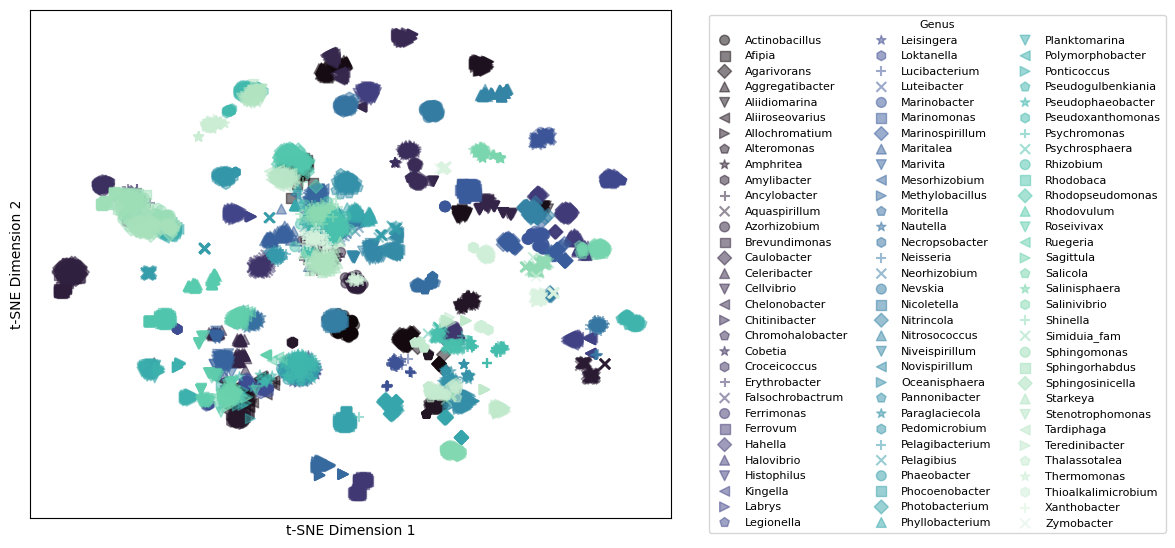

In [ ]:
genera = AMP_updated['Genus'].unique() # unique genera values
coordinates = X_embedded # coordinates from t-SNE

palette = sns.color_palette('mako', n_colors = len(genera)) # color palette with 96 different colors
color_mapping = {genus: palette[i] for i, genus in enumerate(genera)} # map each genus to a color

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x'] # different markers
marker_mapping = {genus: markers[i % len(markers)] for i, genus in enumerate(genera)} # map each genus to a marker

plt.figure(figsize = (12, 6)) # figure size

for genus in genera:
    genus_mask = AMP_updated['Genus'] == genus
    plt.scatter(coordinates[genus_mask, 0], coordinates[genus_mask, 1],
                c = [color_mapping[genus]] * sum(genus_mask),
                marker = marker_mapping[genus],
                label = genus, s = 50, alpha = 0.5) # plot t-SNE coordinates with different markers

plt.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), ncol = 3,
           fontsize = 8, title ='Genus', title_fontsize = 8) # add legend

ax = plt.gca() # get current axis
ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
               labelbottom = False, labelleft = False) # remove axis ticks and labels

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

####  Exploring Patterns at the *Order* Taxonomic Level

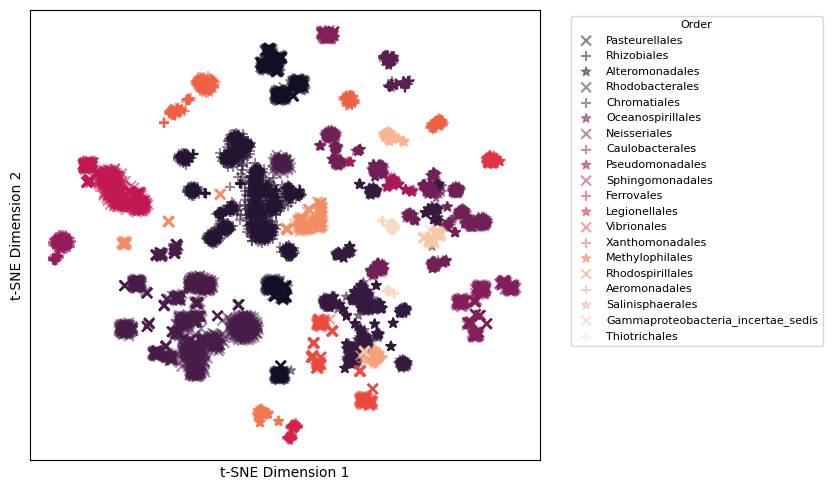

In [ ]:
orders = AMP_updated['Order'].unique() # unique order values
coordinates = X_embedded # coordinates from t-SNE

palette = sns.color_palette('rocket', n_colors = len(orders)) # color palette with 3 different colors
color_mapping = {order: palette[i] for i, order in enumerate(orders)} # map each genus to a color

markers = ['x', '+', '*', 'x', '+', '*', 'x', '+', '*'] # different markers
marker_mapping = {order: markers[i % len(markers)] for i, order in enumerate(orders)} # map each genus to a marker

plt.figure(figsize = (8.5, 5)) # figure size

for order in orders:
    order_mask = AMP_updated['Order'] == order
    plt.scatter(coordinates[order_mask, 0], coordinates[order_mask, 1],
                c = [color_mapping[order]] * sum(order_mask),
                marker = marker_mapping[order],
                label = order, s = 50, alpha = 0.5) # plot t-SNE coordinates with different markers

plt.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), ncol = 1,
           fontsize = 8, title = 'Order',  title_fontsize = 8) # add legend

ax = plt.gca() # get current axis
ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
               labelbottom = False, labelleft = False) # remove axis ticks and labels

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

#### Dimensionality Reduction for Exploring Patterns Among Classes

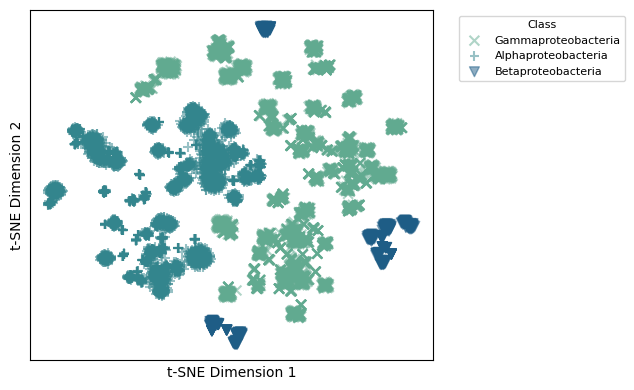

In [ ]:
classes = AMP_updated['Class'].unique() # unique class values
coordinates = X_embedded # coordinates from t-SNE

palette = sns.color_palette('crest', n_colors = len(classes)) # color palette with 3 different colors
color_mapping = {cls: palette[i] for i, cls in enumerate(classes)} # map each genus to a color

markers = ['x', '+', 'v'] # different markers
marker_mapping = {cls: markers[i % len(markers)] for i, cls in enumerate(classes)} # map each genus to a marker

plt.figure(figsize = (6.5, 4)) # figure size

for cls in classes:
    cls_mask = AMP_updated['Class'] == cls
    plt.scatter(coordinates[cls_mask, 0], coordinates[cls_mask, 1],
                c = [color_mapping[cls]] * sum(cls_mask),
                marker = marker_mapping[cls],
                label = cls, s = 50, alpha = 0.5) # plot t-SNE coordinates with different markers

plt.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), ncol = 1,
           fontsize = 8, title = 'Class',  title_fontsize = 8) # add legend

ax = plt.gca() # get current axis
ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
               labelbottom = False, labelleft = False) # remove axis ticks and labels

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

*For topology, you may need more than one plot*.

(Wattenberg, et al. 2016)

The **perplexity** value has a complex effect on the resulting pictures, it influences how the algorithm balances local and global structure in the visualization.

In [ ]:
X_embedded = TSNE(n_components = 2, learning_rate = 'auto',
                  init = 'random', perplexity = 50).fit_transform(X) # fit data into an embedded space and return that transformed output

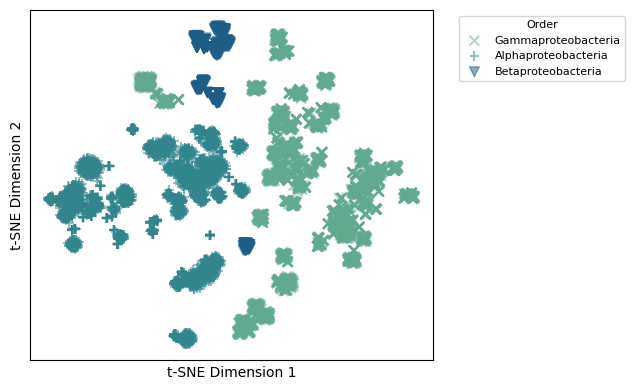

In [ ]:
orders = AMP_updated['Class'].unique() # unique order values
coordinates = X_embedded # coordinates from t-SNE

palette = sns.color_palette('crest', n_colors = len(orders)) # color palette with 3 different colors
color_mapping = {order: palette[i] for i, order in enumerate(orders)} # map each genus to a color

markers = ['x', '+', 'v'] # different markers
marker_mapping = {order: markers[i % len(markers)] for i, order in enumerate(orders)} # map each genus to a marker

plt.figure(figsize = (6.5, 4)) # figure size

for order in orders:
    order_mask = AMP_updated['Class'] == order
    plt.scatter(coordinates[order_mask, 0], coordinates[order_mask, 1],
                c = [color_mapping[order]] * sum(order_mask),
                marker = marker_mapping[order],
                label = order, s = 50, alpha = 0.5) # plot t-SNE coordinates with different markers

plt.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), ncol = 1,
           fontsize = 8, title = 'Class',  title_fontsize = 8) # add legend

ax = plt.gca() # get current axis
ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
               labelbottom = False, labelleft = False) # remove axis ticks and labels

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

Although no clear patterns are observed at either taxonomic level, it's important to note that we're only considering the first two components. Consequently, significant information that could aid in distinguishing between genera and classes may be overlooked.

Dimensionality reduction methods are primarily used to visualize potential patterns in the data. However, ML models use all the available features as input, enabling classification models leverage the full complexity of the dataset.

## Supervised Learning Models for Bacteria Species Classiﬁcation

Since ML models require numerical labels, we use `LabelEncoder` to convert the Genera column into numerical categories.

In [ ]:
encoder = LabelEncoder() # enconde target labels with values between 0 and no. of genera - 1
y = encoder.fit_transform(y) # encoded labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42) # split data in train and test sets

### Performance Comparison of Classification Models Using K-Fold Cross-Validation

In [ ]:
models = [] # empty list to store model objects

In [ ]:
# Base Models (i.e. an individual predictive model)
models.append(('SVM', SVC(C = 1.0, kernel = 'rbf', decision_function_shape = 'ovo', random_state = 0))) # support vector machine classifier (rbf kernel)
models.append(('SVM (Polynomial)', SVC(C = 1.0, kernel = 'poly', degree = 3, decision_function_shape = 'ovo', random_state = 0))) # support vector machine classifier (polynomial kernel)
models.append(('Decision Tree', DecisionTreeClassifier(criterion = 'entropy', max_depth = 40, random_state = 0))) # decision tree classifier
models.append(('MLP', MLPClassifier(activation = 'relu', solver = 'adam', alpha = 0.32, max_iter = 1000, random_state = 0))) # multi-layer perceptron classifier

# Ensemble Methods (i.e. combines predictions from multiple base models)
models.append(('Bagging', BaggingClassifier(estimator = SVC(), n_estimators = 100, max_features = 0.5, random_state = 0))) # bagging classifier
models.append(('Random Forest', RandomForestClassifier(n_estimators = 150, max_depth = None, criterion = 'gini', random_state = 0))) # random forest classifier
models.append(('XGBoost', XGBClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3, objective = 'multi:softmax', random_state = 0))) # XGBoost classifier

In [ ]:
names = []
times = []
results = [] # empty lists to store results, model names and execution times

**UPDATE**

Use `StratifiedKFold` instead `KFold`.

`StratifiedKFold` ensures that the class distribution in each fold is approximately the same as in the entire dataset, just like the **stratify** argument in `train_test_split`.

In [ ]:
metric = 'accuracy'
stratified_kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42) # stratified K-Fold cross-validator

for name, model in models: # iterate over all models defined above
    start_time = time.time() # start time
    cv_results = cross_val_score(model, X, y, cv = stratified_kfold, scoring = metric) # return accuracy score for each fold
    elapsed_time = (time.time() - start_time) / 10 # avg time per fold

    results.append(cv_results * 100)
    names.append(name)
    times.append(elapsed_time) # store results (percentage), model name, and average execution time per fold

    summary = '%s: Mean Accuracy %.2f, Standard Deviation %.2f, Execution Time: %.2f seconds' % (name, cv_results.mean(), cv_results.std(), elapsed_time)
    print(summary)

SVM: Mean Accuracy 0.88, Standard Deviation 0.01, Execution Time: 28.48 seconds
SVM (Polynomial): Mean Accuracy 0.88, Standard Deviation 0.02, Execution Time: 26.35 seconds
Decision Tree: Mean Accuracy 0.67, Standard Deviation 0.03, Execution Time: 1.75 seconds
MLP: Mean Accuracy 0.87, Standard Deviation 0.02, Execution Time: 94.74 seconds
Bagging: Mean Accuracy 0.88, Standard Deviation 0.02, Execution Time: 536.41 seconds
Random Forest: Mean Accuracy 0.87, Standard Deviation 0.01, Execution Time: 5.27 seconds
XGBoost: Mean Accuracy 0.85, Standard Deviation 0.01, Execution Time: 250.47 seconds


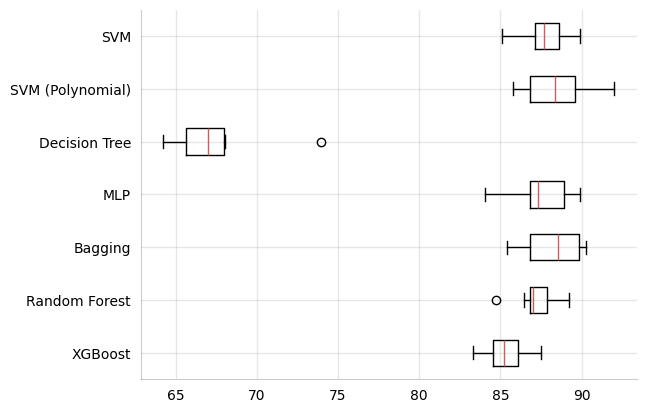

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.boxplot(results, notch = False, vert = False, medianprops = dict(color = 'indianred')) # horizontal boxplots for accuracy scores

plt.tick_params(axis = 'x', which = 'both', bottom = False)
plt.tick_params(axis = 'y', which = 'both', left = False) # remove axes ticks

ax.set_yticklabels(names) # set y-axis labels

ax.grid(True, linestyle = '-', linewidth = 1, alpha = 0.3) # add a grid

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
for spine in ax.spines.values():
    spine.set_alpha(0.2) # customize the visibility of plot spines

plt.show() # show plot

For optimal performance, SVM methods stand out due to their combination of high accuracy, robustness, and reasonable execution times.

This project highlights the power of Machine Learning models in analyzing complex metagenomic data, demonstrating that **k-mer frequency vectorization effectively captures patterns for accurate bacterial classification**. By integrating Bioinformatics and Machine Learning, it underscores the critical role of interdisciplinary approaches in extracting deeper biological insights.

***

December 2024